In [1]:
from functions import *
from step1_functions import *
import pandas as pd
from time_stitches import *
from sklearn.cluster import KMeans, DBSCAN
import warnings


warnings.filterwarnings('ignore')

In [2]:
def DBSCAN_ (data, eps=0.02, min_samples=10):
    selected_data = data[:, 1:4]

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Ajustement de DBSCAN sur les données sélectionnées
    dbscan.fit(selected_data)

    # Obtention des étiquettes
    labels = dbscan.labels_

    return labels

In [3]:
def Kmeans_ (data, number_of_clusters):   
    # Selecting a subset of data for clustering
    selected_data = data[:, 1:4]
    # Initialize KMeans with specified number of clusters
    kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init=15, random_state=42)
    # Fitting KMeans on the selected data
    kmeans.fit(selected_data)
    # Getting the labels and centroids from KMeans
    labels = kmeans.labels_

    return labels

Subject: 19


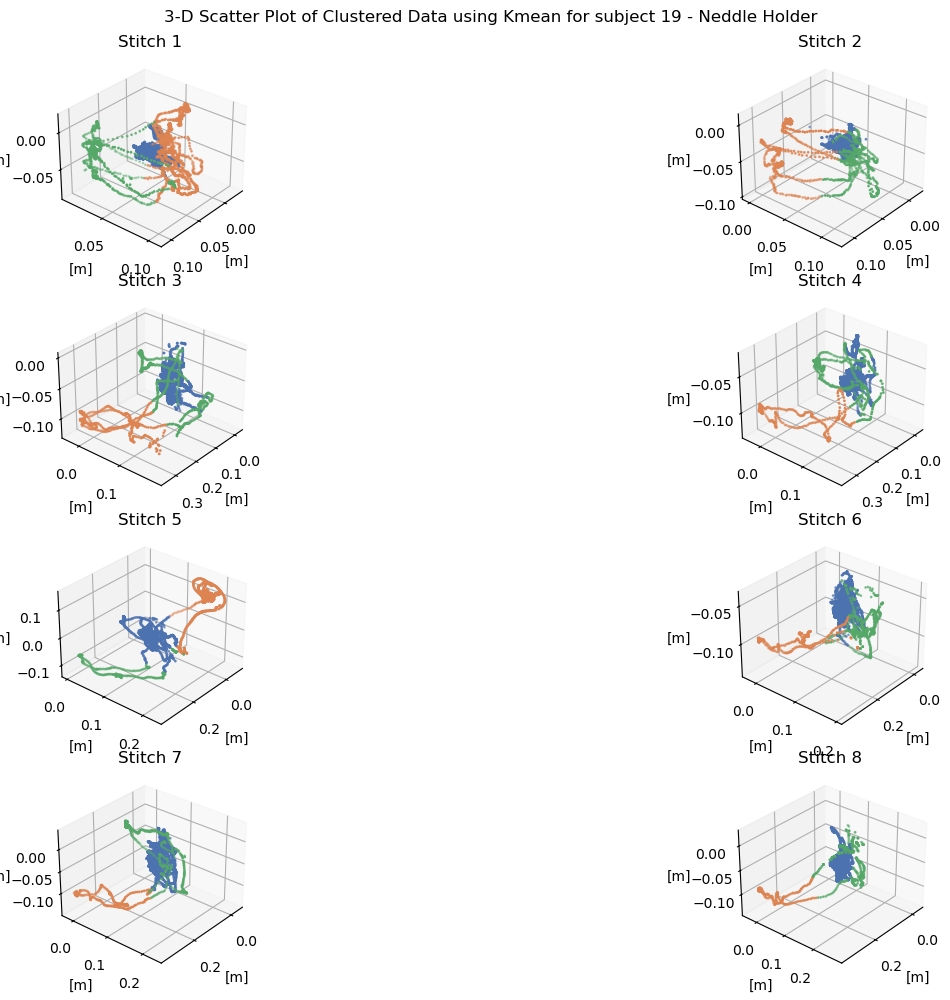

KeyboardInterrupt: 

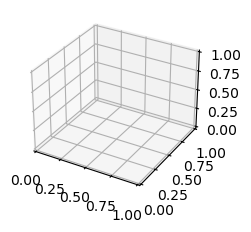

In [4]:
eps = [0.03, 0.03, 0.03]
m = [200, 200, 200]
i_ = [1,6,11]
subjects = [19,10,27]
for index,subject in enumerate(subjects):
    print('Subject:', subject)
    i = i_[index]
    dict_segment_time = full_segments_time[i]
    #dict_segment_time = full_segments_time[i]
            
    #tweezers_raw = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_raw.csv')
    tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')
    #needle_holder_raw = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_raw.csv')
    needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')

    #list_np_segmented_tw_raw = pd_2_numpy_and_segment(tweezers_raw, dict_segment_time)
    list_np_segmented_tw_rec = pd_2_numpy_and_segment(tweezers_rec, dict_segment_time)
    #list_np_segmented_nh_raw = pd_2_numpy_and_segment(needle_holder_raw, dict_segment_time)
    list_np_segmented_nh_rec = pd_2_numpy_and_segment(needle_holder_rec, dict_segment_time)

    #Kmean
    number_of_clusters = 3
    palette = sns.color_palette("deep", number_of_clusters)
    fig = plt.figure(figsize=(17, 10))
    plt.subplots_adjust(wspace=1, hspace=0.9)
    for s in range(8):
        ax = fig.add_subplot(2, 4, s+1, projection='3d')
        clusters_info = cluster_data_points(list_np_segmented_nh_rec[s], number_of_clusters)
        plot_clustered_data_3D_g2(0, 0, s, clusters_info, list_np_segmented_nh_rec[s], ax, palette)
        ax.view_init( azim=40)
    fig.suptitle(f'3-D Scatter Plot of Clustered Data using Kmean for subject {subject} - Neddle Holder')
    plt.tight_layout()
    plt.show()


    fig = plt.figure(figsize=(17, 10))
    plt.subplots_adjust(wspace=1, hspace=0.9)
    for s in range(8):
        ax = fig.add_subplot(2, 4, s+1, projection='3d')
        clusters_info = cluster_data_points_DBSCAN(list_np_segmented_nh_rec[s], eps=eps[index], min_samples=m[index])
        palette = sns.color_palette("deep", len(clusters_info))
        plot_clustered_data_3D_g2(0, 0, s, clusters_info, list_np_segmented_nh_rec[s], ax, palette)
        ax.view_init( azim=40)
    fig.suptitle(f'3-D Scatter Plot of Clustered Data using DBSCAN subject {subject} (Min nbr of sample ={m[index]}, eps = {eps[index]}) - Needle Holder')
    plt.tight_layout()
    plt.show()

Automatic segmentation of points

Subject: 19


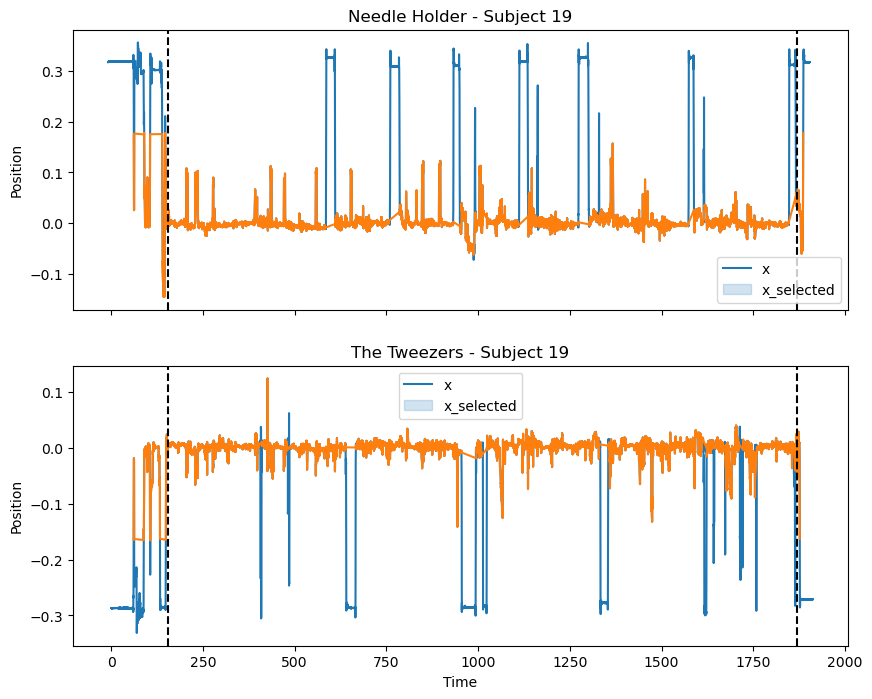

Subject: 10


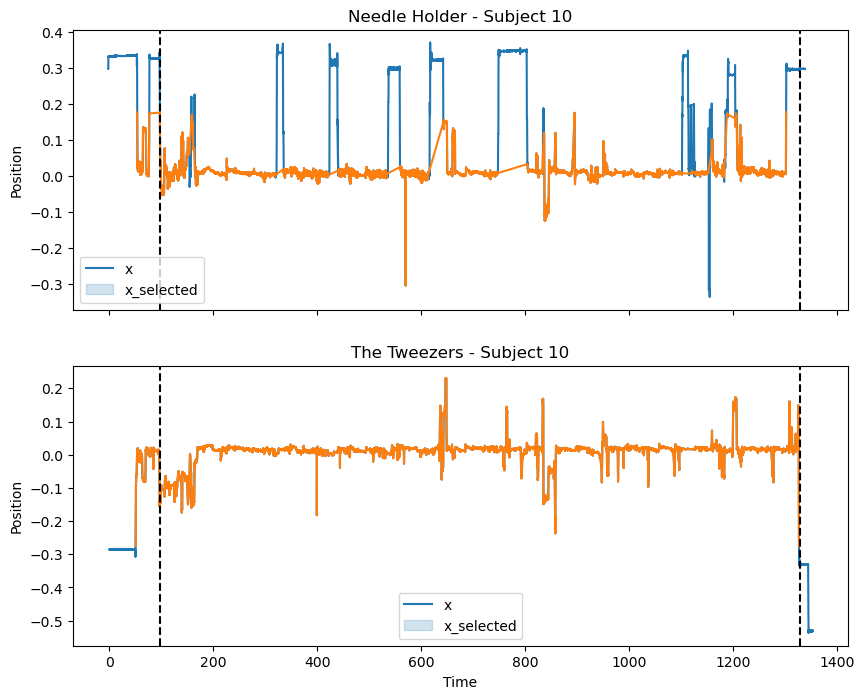

Subject: 27


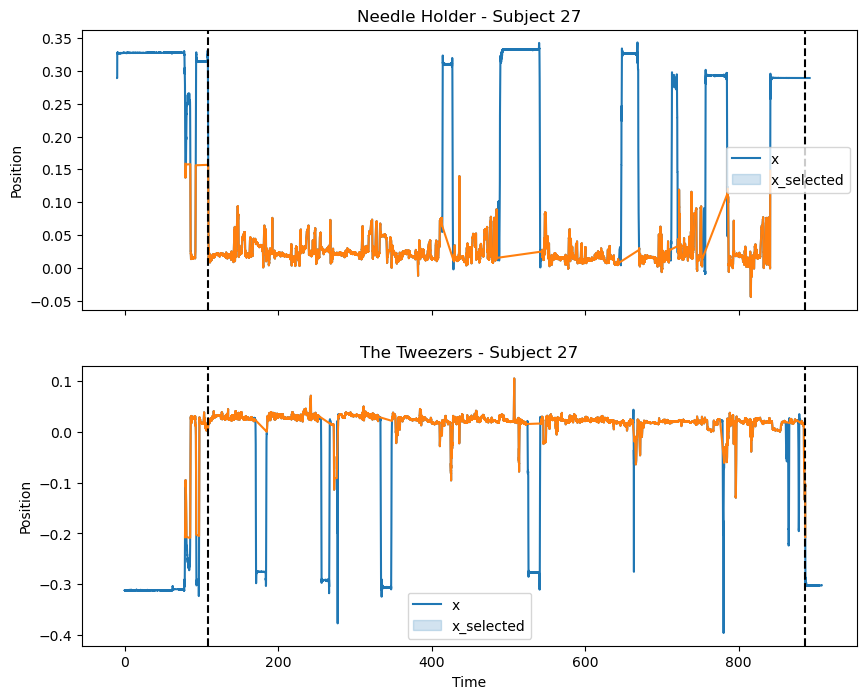

In [6]:
i_ = [1,6,11]
subjects = [19,10,27]
for index,subject in enumerate(subjects):
    print('Subject:', subject)
    i = i_[index]
    needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
    tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')

    medians_nh = (needle_holder_rec[['X.1', 'Y.1', 'Z.1']]).median()
    medians_tw = (tweezers_rec[['X.1', 'Y.1', 'Z.1']]).median()

    """Position"""
    selected_xpos_nh, selected_xpos_tw = remove_extreme_using_x_pos(needle_holder_rec, tweezers_rec, prop_nh=0.5, prop_tw=0.5)
    time_event_xpos_nh, time_event_xpos_tw = compute_event_time_x_pos(full_segments_time[i], needle_holder_rec, tweezers_rec, selected_xpos_nh,
                                                                selected_xpos_tw)

    pairs_t_xpos_nh = compute_pairs_time(time_event_xpos_nh[0], time_event_xpos_nh[1])
    pairs_t_xpos_tw = compute_pairs_time(time_event_xpos_tw[0], time_event_xpos_tw[1])

    pairs_adjusted_t_xpos_nh = adjust_time_pair(needle_holder_rec, pairs_t_xpos_nh, medians_nh['X.1'], time_allowed = 6)
    pairs_adjusted_t_xpos_tw = adjust_time_pair(tweezers_rec, pairs_t_xpos_tw, medians_tw['X.1'], time_allowed=6)

    mask_extreme_xpos_event_removed_nh = remove_extreme_using_v_time(needle_holder_rec, pairs_adjusted_t_xpos_nh)
    mask_extreme_xpos_event_removed_tw = remove_extreme_using_v_time(tweezers_rec, pairs_adjusted_t_xpos_tw)

    """Velocity"""
    mask_min_max_nh, mask_min_max_tw = compute_mask_using_v(needle_holder_rec, tweezers_rec, smooth_window=60, prop_nh=0.4, prop_tw=0.4)
    time_event_nh, time_event_tw = compute_event_time(full_segments_time[i], needle_holder_rec, tweezers_rec, mask_min_max_nh[0],  
                                                            mask_min_max_nh[1], mask_min_max_tw[0], mask_min_max_tw[1])

                
    pairs_t_nh = compute_pairs_time(time_event_nh[0], time_event_nh[1])
    pairs_t_tw = compute_pairs_time(time_event_tw[0], time_event_tw[1])

    pairs_adjusted_t_nh = adjust_time_pair(needle_holder_rec, pairs_t_nh, medians_nh['X.1'], time_allowed = 6)
    pairs_adjusted_t_tw = adjust_time_pair(tweezers_rec, pairs_t_tw, medians_tw['X.1'], time_allowed = 6)

    mask_extreme_v_event_removed_nh = remove_extreme_using_v_time(needle_holder_rec, pairs_adjusted_t_nh)
    mask_extreme_v_event_removed_tw = remove_extreme_using_v_time(tweezers_rec, pairs_adjusted_t_tw)

    #mask_extreme_v_event_removed_nh = remove_extreme_using_v_time(needle_holder_rec, pairs_t_nh)
    #mask_extreme_v_event_removed_tw = remove_extreme_using_v_time(tweezers_rec, pairs_t_tw)

    selected_points_nh = needle_holder_rec[mask_extreme_xpos_event_removed_nh & mask_extreme_v_event_removed_nh & selected_xpos_nh]
    selected_points_tw = tweezers_rec[mask_extreme_xpos_event_removed_tw & mask_extreme_v_event_removed_tw & selected_xpos_tw]


    start_t_task = full_segments_time[i]['1'][0]
    end_t_task = full_segments_time[i]['8'][1]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Tracer les données pour 'bh'
    sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
    sns.lineplot(x=selected_points_nh['Time (Seconds)'], y=selected_points_nh['X.1'], ax=ax1)
    ax1.axvline(x=start_t_task, color='black', linestyle='--')
    ax1.axvline(x=end_t_task, color='black', linestyle='--')

    """ax1_secondary_y = ax1.twinx()

    sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=smooth_vx_nh, ax=ax1_secondary_y, color = 'orange')
    ax1_secondary_y.axhline(y=max(smooth_vx_nh)/2, color='black', linestyle='--')
    ax1_secondary_y.set_ylabel('vx_smooth', color='orange')
    ax1_secondary_y.tick_params(axis='y', labelcolor='orange') """

            
    #ax1.set_title(f'Pos and v according to time (Subject {subject}, Needle holder)')
    ax1.set_xlabel('Time')
    ax1.set_xlim(start_t_task, start_t_task+350)
    ax1.set_ylabel('Position')
    ax1.set_title(f'Needle Holder - Subject {subject}')
    ax1.legend(['x', 'x_selected'])


    # Tracer les données pour 'tw'
    sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
    sns.lineplot(x=selected_points_tw['Time (Seconds)'], y=selected_points_tw['X.1'], ax=ax2)
    ax2.axvline(x=start_t_task, color='black', linestyle='--')
    ax2.axvline(x=end_t_task, color='black', linestyle='--')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Position')
    ax2.legend(['x', 'x_selected'])
    ax2.set_title(f'The Tweezers - Subject {subject}')
    plt.show()



In [73]:
def cut_in_stitches(pd_frame, dict):
    t = pd_frame['Time (Seconds)'].to_numpy()
    # Calculate time differences (dt) between consecutive samples
    # dt = np.diff(t)
    # # Calculate the mean value of dt, which is the average sampling period
    # mean_sampling_period = np.mean(dt)
    # print(f"mean: {1.0 / mean_sampling_period}")
    x = pd_frame['X.1'].to_numpy()
    y = pd_frame['Y.1'].to_numpy()
    z = pd_frame['Z.1'].to_numpy()
    """q_w = pd_frame['W'].to_numpy()
    q_x = pd_frame['X'].to_numpy()
    q_y = pd_frame['Y'].to_numpy()
    q_z = pd_frame['Z'].to_numpy()"""
    list_segmented_stitches = [None] * 8
    i = 0
    for key, value in dict.items():
        t_start, t_end = value 
        mask = (t >= t_start) & (t <= t_end)
        tmp = np.zeros((t[mask].shape[0], 11))
        tmp[:,0] = t[mask]
        tmp[:,1] = x[mask]
        tmp[:,2] = y[mask]
        tmp[:,3] = z[mask] 
        """tmp[:,4] = q_w[mask]
        tmp[:,5] = q_x[mask]
        tmp[:,6] = q_y[mask]
        tmp[:,7] = q_z[mask]
        tmp[:,8] = convert_quaternion_to_euler(tmp[:, 4:8])[:, 0]
        tmp[:,9] = convert_quaternion_to_euler(tmp[:, 4:8])[:, 1]
        tmp[:,10] = convert_quaternion_to_euler(tmp[:, 4:8])[:, 2]"""
        list_segmented_stitches[i] = tmp
        i = i + 1
    return list_segmented_stitches

In [ ]:
def plot_clustered_data_3D_g3(subject_id, tool_name, segment_id, cluster, data, ax, cluster_color):
    print(cluster)
    indices = (cluster==1)
    ax.scatter(data[indices, 1], data[indices, 2], data[indices, 3], color=cluster_color[0], label=f'Cluster 1', s=1)
    
    indices2 = (cluster==0)
    ax.scatter(data[indices2, 1], data[indices2, 2], data[indices2, 3], color=cluster_color[1], label=f'Cluster 2', s=1)

    ax.set_xlabel('[m]')
    ax.set_ylabel('[m]')
    ax.set_zlabel('[m]')
    ax.set_title(f'Stitch {segment_id+1}')

In [77]:
def plot_clustered_data_3D_g3(selected_data, not_selected_data, segment_id, ax, cluster_color):
    ax.scatter(selected_data[:, 1], selected_data[:, 2], selected_data[:, 3], color=cluster_color[0], label=f'Cluster 1', s=1)
    
    ax.scatter(not_selected_data[:, 1], not_selected_data[:, 2], not_selected_data[:, 3], color=cluster_color[1], label=f'Cluster 2', s=1)

    ax.set_xlabel('[m]')
    ax.set_ylabel('[m]')
    ax.set_zlabel('[m]')
    ax.set_title(f'Stitch {segment_id+1}')

Subject: 19


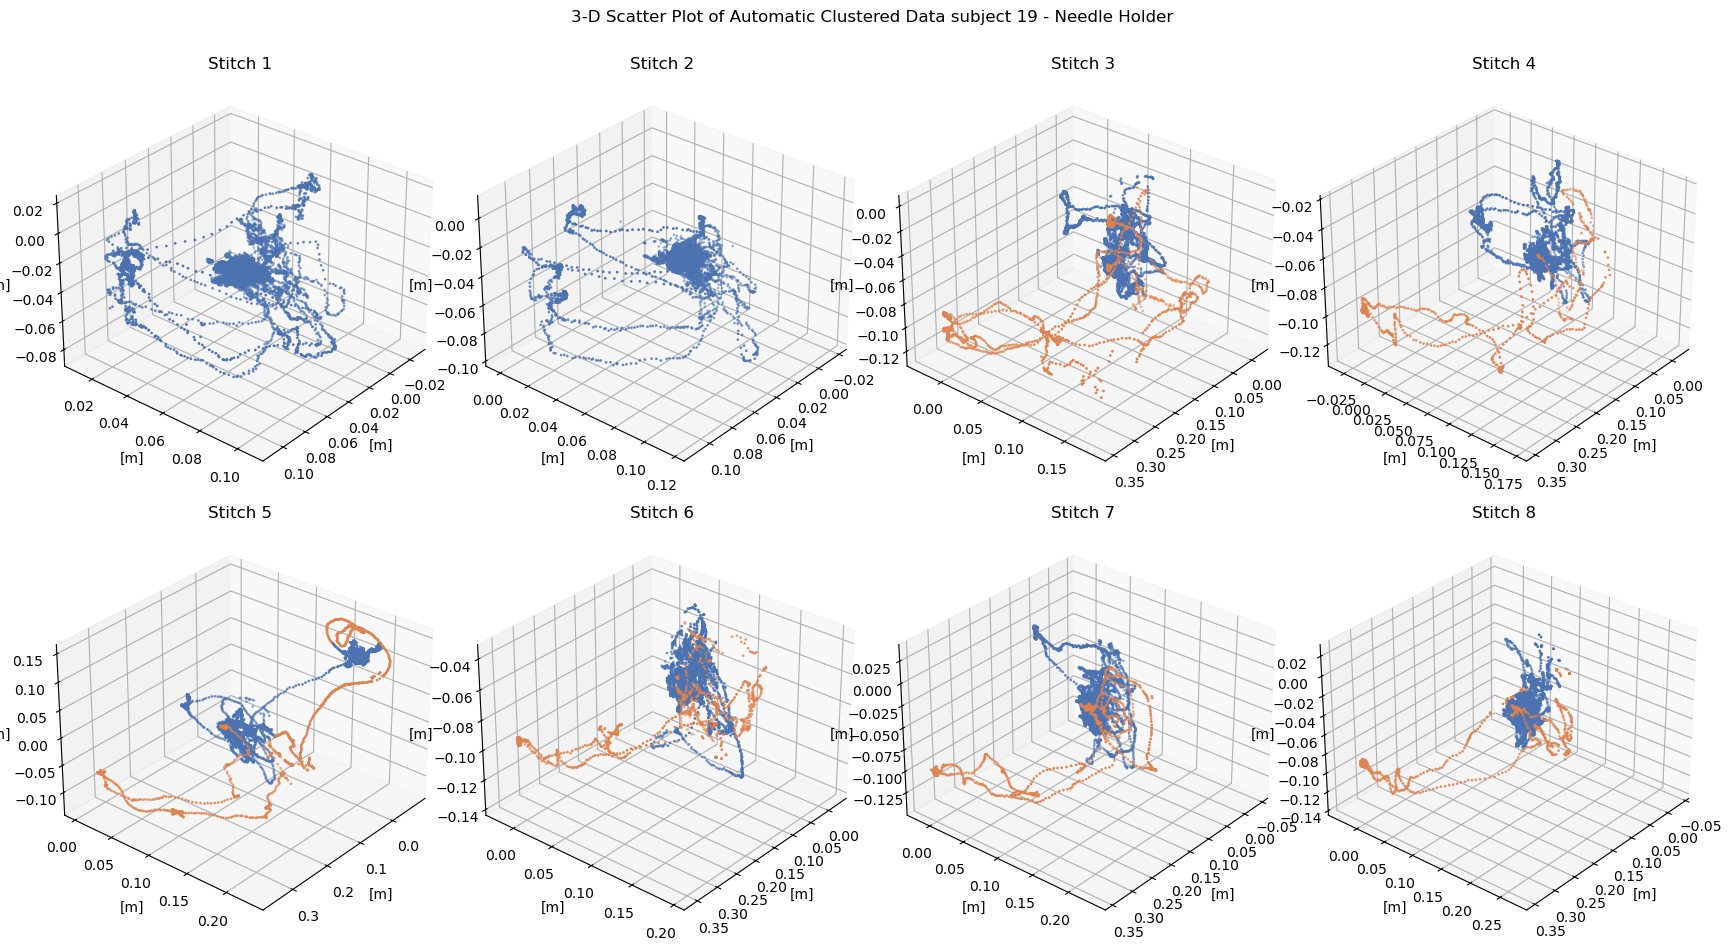

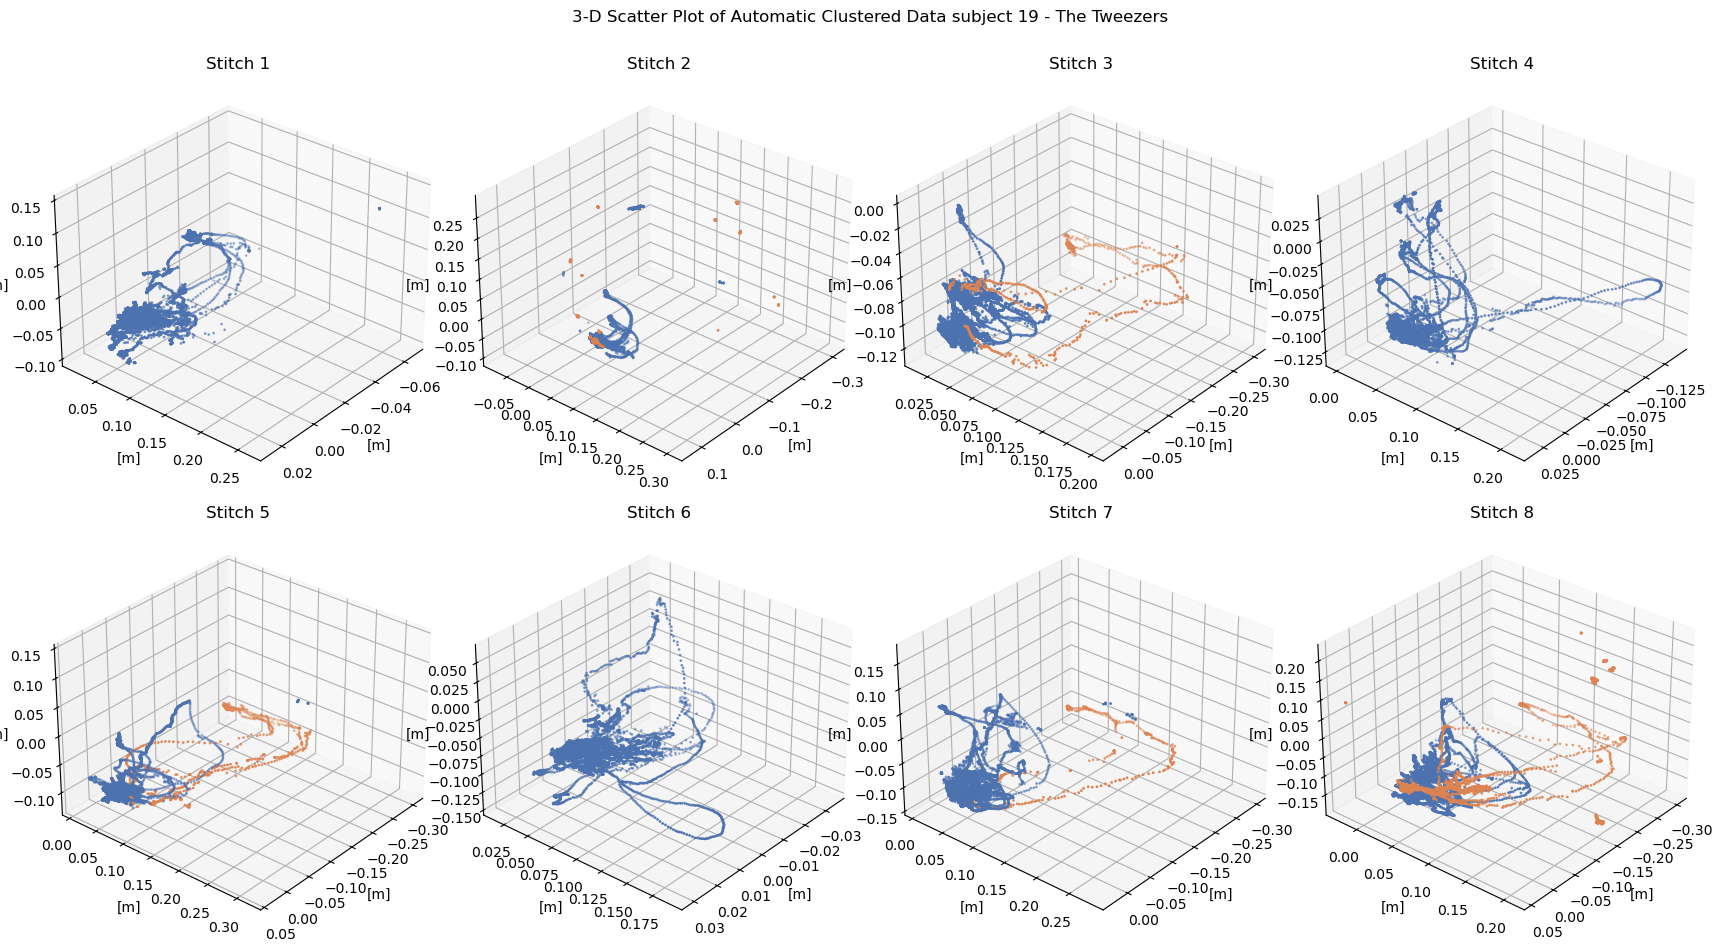

Subject: 10


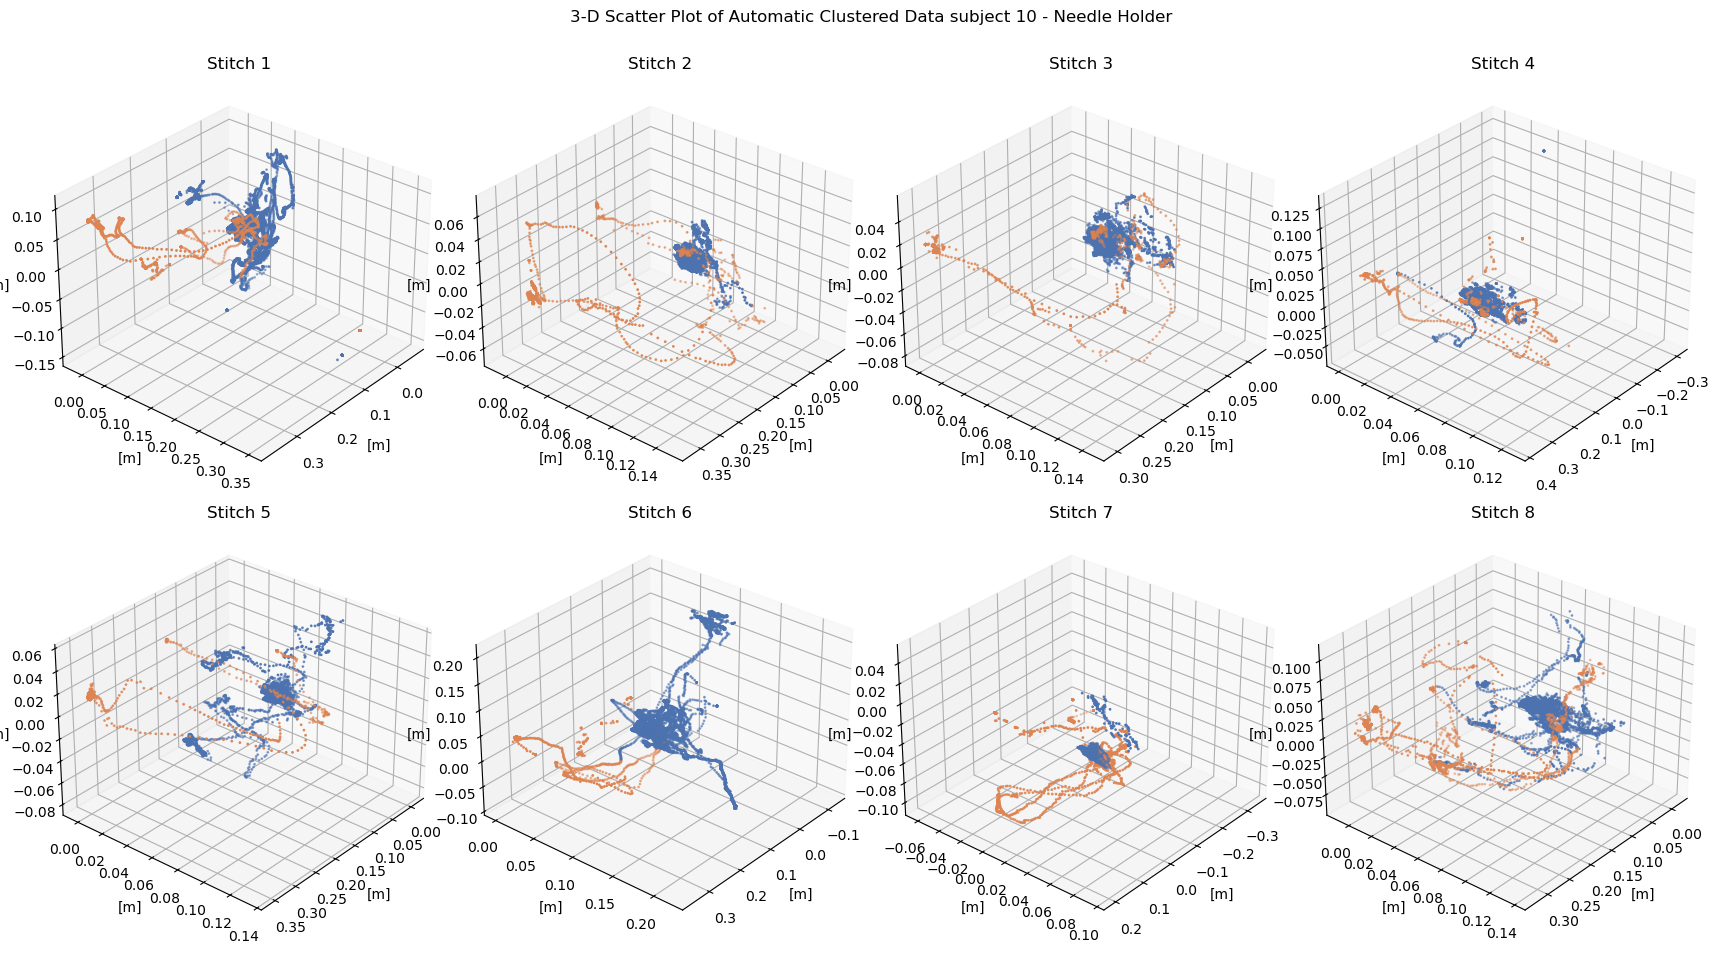

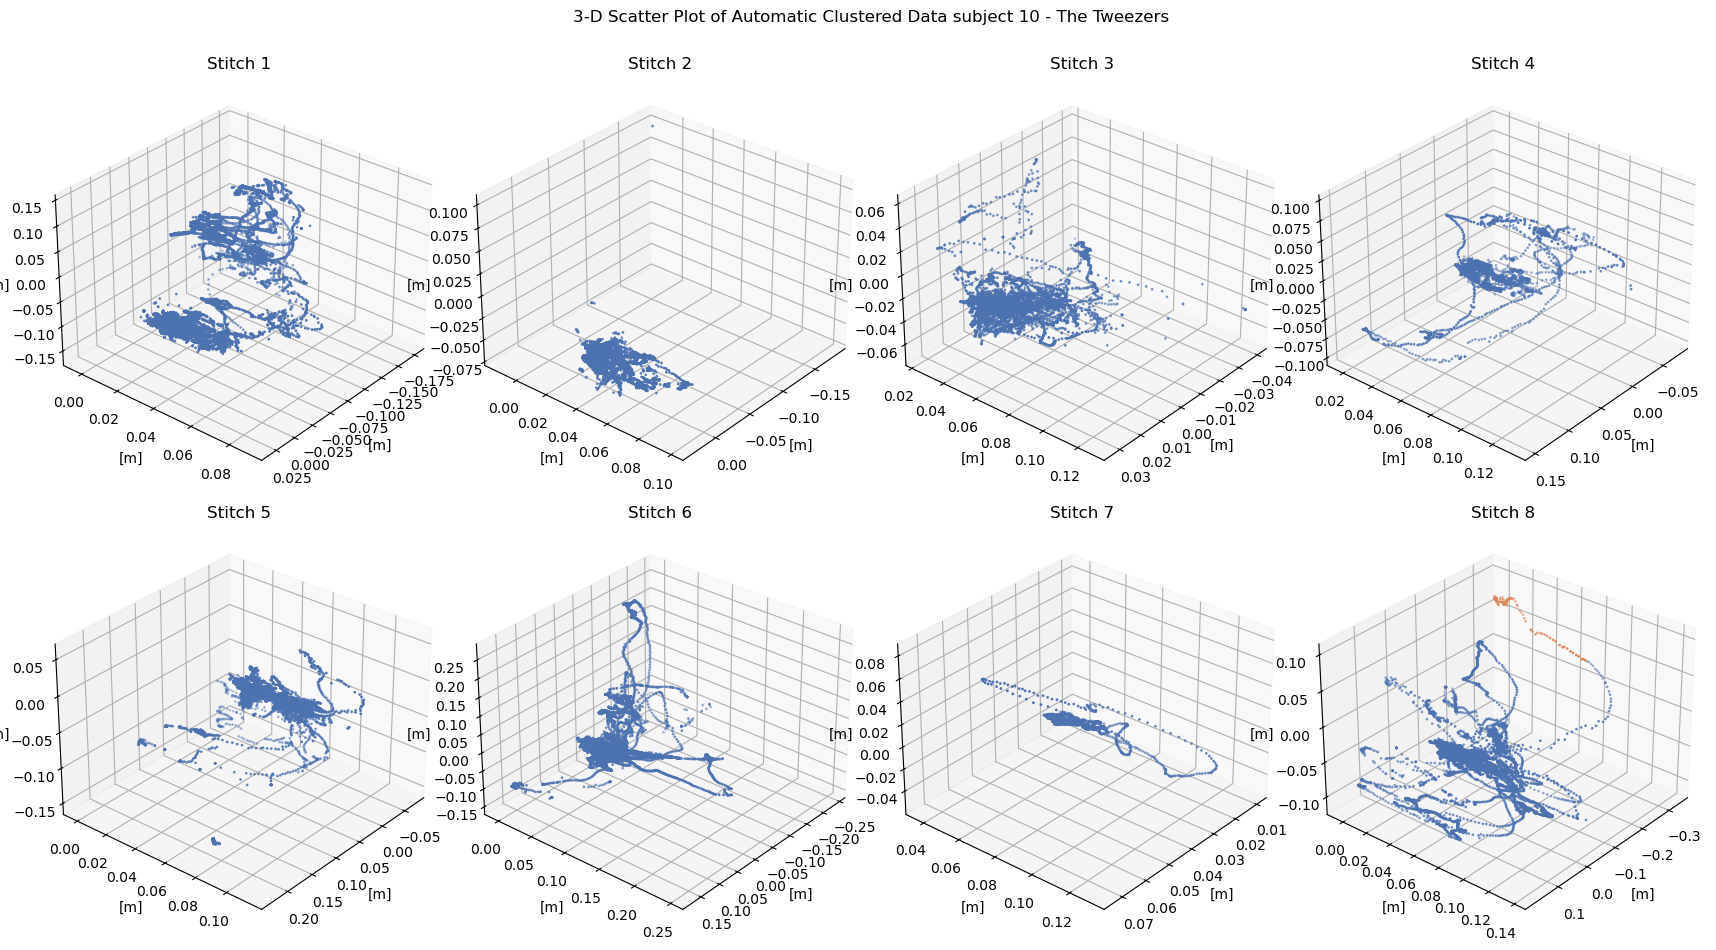

Subject: 27


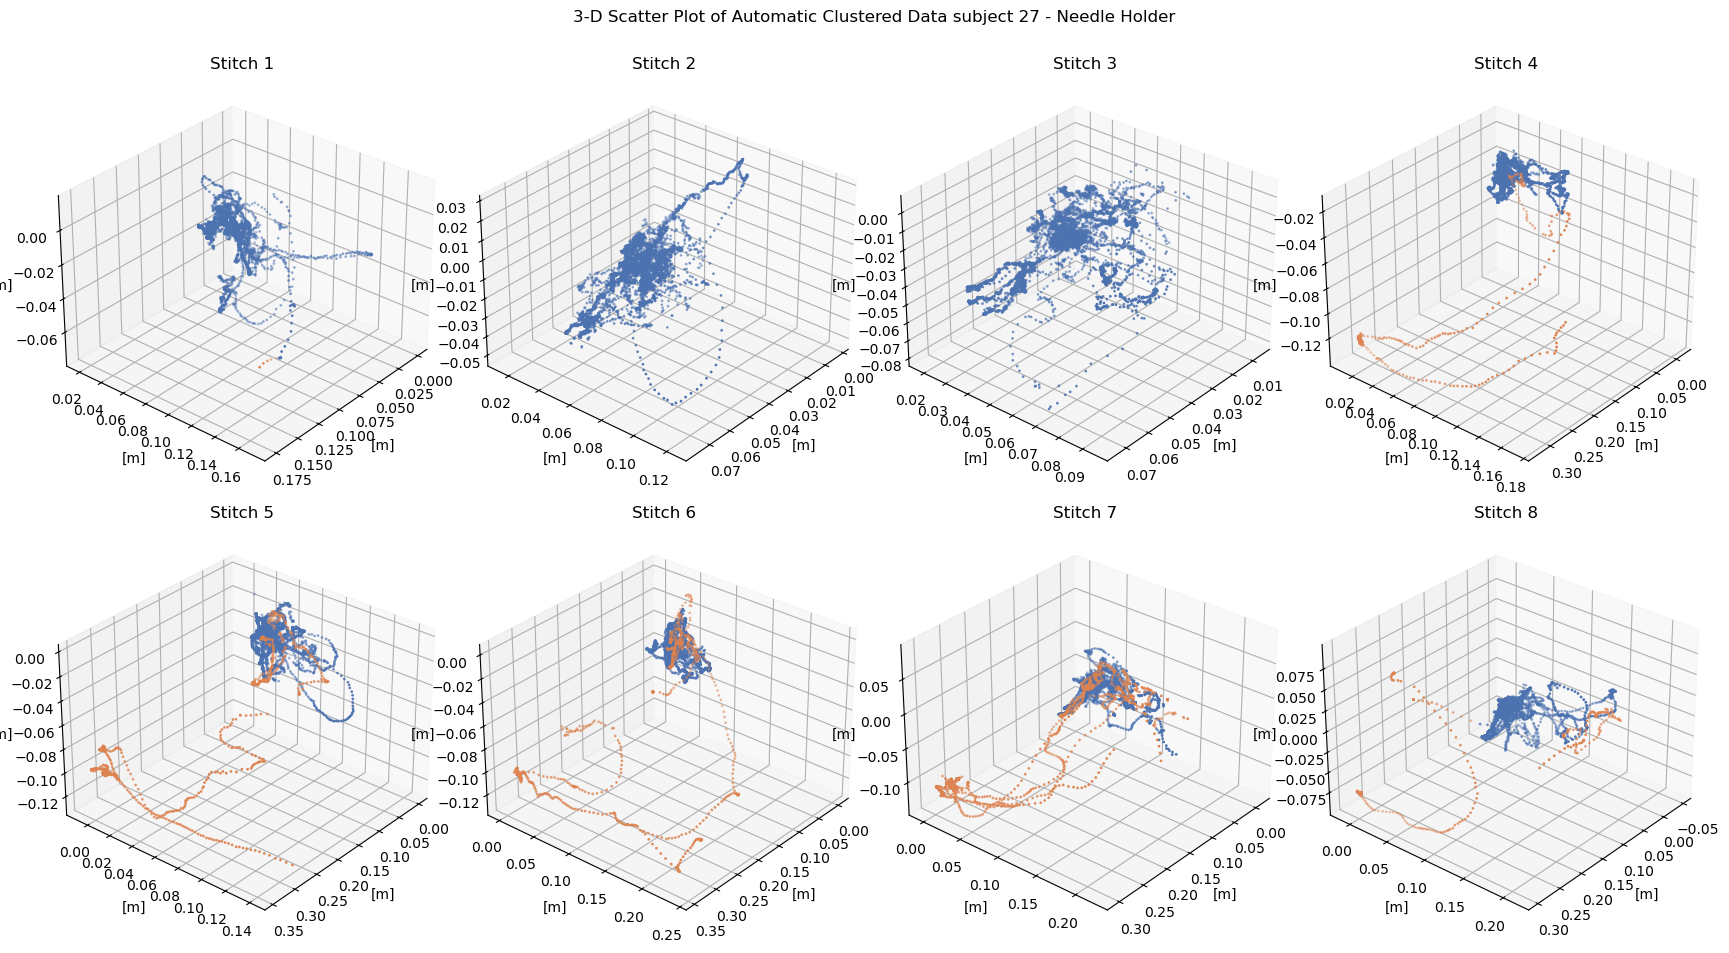

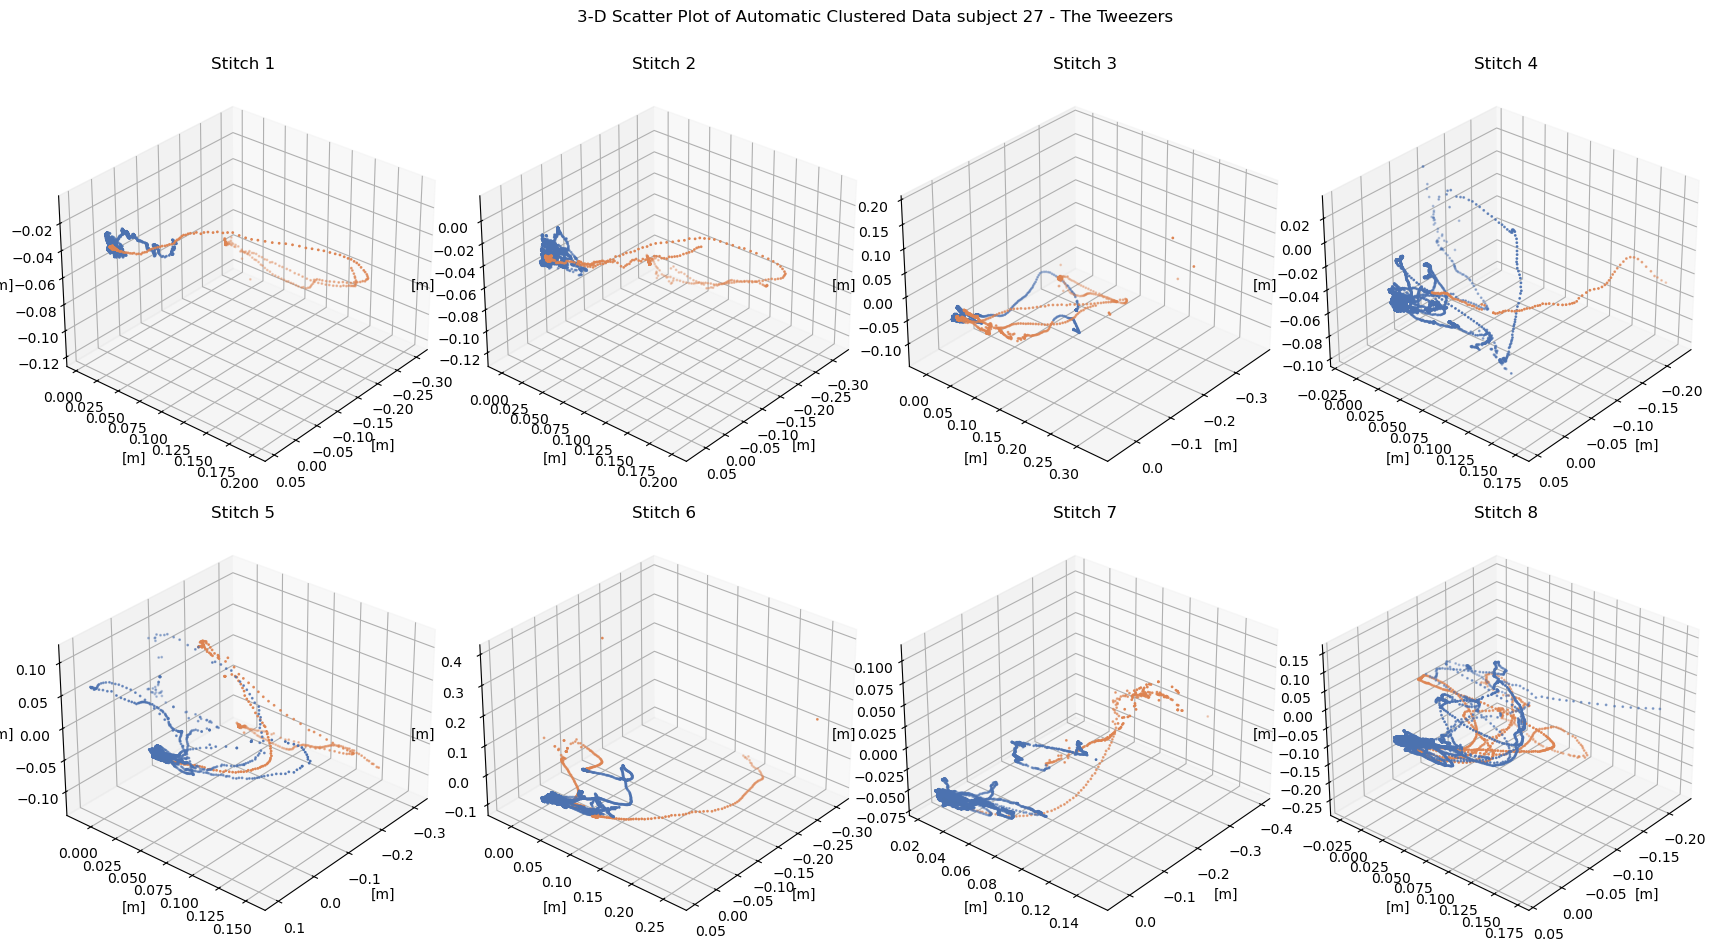

In [80]:
i_ = [1,6,11]
subjects = [19,10,27]
for index,subject in enumerate(subjects):
    print('Subject:', subject)
    i = i_[index]
    needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
    tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')

    medians_nh = (needle_holder_rec[['X.1', 'Y.1', 'Z.1']]).median()
    medians_tw = (tweezers_rec[['X.1', 'Y.1', 'Z.1']]).median()

    """Position"""
    selected_xpos_nh, selected_xpos_tw = remove_extreme_using_x_pos(needle_holder_rec, tweezers_rec, prop_nh=0.5, prop_tw=0.5)
    time_event_xpos_nh, time_event_xpos_tw = compute_event_time_x_pos(full_segments_time[i], needle_holder_rec, tweezers_rec, selected_xpos_nh,
                                                                selected_xpos_tw)

    pairs_t_xpos_nh = compute_pairs_time(time_event_xpos_nh[0], time_event_xpos_nh[1])
    pairs_t_xpos_tw = compute_pairs_time(time_event_xpos_tw[0], time_event_xpos_tw[1])

    pairs_adjusted_t_xpos_nh = adjust_time_pair(needle_holder_rec, pairs_t_xpos_nh, medians_nh['X.1'], time_allowed = 6)
    pairs_adjusted_t_xpos_tw = adjust_time_pair(tweezers_rec, pairs_t_xpos_tw, medians_tw['X.1'], time_allowed=6)

    mask_extreme_xpos_event_removed_nh = remove_extreme_using_v_time(needle_holder_rec, pairs_adjusted_t_xpos_nh)
    mask_extreme_xpos_event_removed_tw = remove_extreme_using_v_time(tweezers_rec, pairs_adjusted_t_xpos_tw)

    """Velocity"""
    mask_min_max_nh, mask_min_max_tw = compute_mask_using_v(needle_holder_rec, tweezers_rec, smooth_window=60, prop_nh=0.4, prop_tw=0.4)
    time_event_nh, time_event_tw = compute_event_time(full_segments_time[i], needle_holder_rec, tweezers_rec, mask_min_max_nh[0],  
                                                            mask_min_max_nh[1], mask_min_max_tw[0], mask_min_max_tw[1])

                
    pairs_t_nh = compute_pairs_time(time_event_nh[0], time_event_nh[1])
    pairs_t_tw = compute_pairs_time(time_event_tw[0], time_event_tw[1])

    pairs_adjusted_t_nh = adjust_time_pair(needle_holder_rec, pairs_t_nh, medians_nh['X.1'], time_allowed = 6)
    pairs_adjusted_t_tw = adjust_time_pair(tweezers_rec, pairs_t_tw, medians_tw['X.1'], time_allowed = 6)

    mask_extreme_v_event_removed_nh = remove_extreme_using_v_time(needle_holder_rec, pairs_adjusted_t_nh)
    mask_extreme_v_event_removed_tw = remove_extreme_using_v_time(tweezers_rec, pairs_adjusted_t_tw)

    selected_points_nh = needle_holder_rec[mask_extreme_xpos_event_removed_nh & mask_extreme_v_event_removed_nh & selected_xpos_nh]
    selected_points_tw = tweezers_rec[mask_extreme_xpos_event_removed_tw & mask_extreme_v_event_removed_tw & selected_xpos_tw]

    #pour le plot
    dict_segment_time = full_segments_time[i]
    not_selected_points_nh = needle_holder_rec[~(mask_extreme_xpos_event_removed_nh & mask_extreme_v_event_removed_nh & selected_xpos_nh)]
    selected_stitches_nh = pd_2_numpy_and_segment(selected_points_nh, dict_segment_time)
    not_selected_stitches_nh = cut_in_stitches(not_selected_points_nh, dict_segment_time)

    fig = plt.figure(figsize=(17, 10))
    plt.subplots_adjust(wspace=1, hspace=0.9)
    for s in range(8):
        ax = fig.add_subplot(2, 4, s+1, projection='3d')
        palette = sns.color_palette("deep", 2)
        plot_clustered_data_3D_g3(selected_stitches_nh[s], not_selected_stitches_nh[s], s, ax, palette)
        ax.view_init( azim=40)
    fig.suptitle(f'3-D Scatter Plot of Automatic Clustered Data subject {subject} - Needle Holder')
    plt.tight_layout()
    plt.show()

    not_selected_points_tw = tweezers_rec[~(mask_extreme_xpos_event_removed_tw & mask_extreme_v_event_removed_tw & selected_xpos_tw)]
    selected_stitches_tw = pd_2_numpy_and_segment(selected_points_tw, dict_segment_time)
    not_selected_stitches_tw = cut_in_stitches(not_selected_points_tw, dict_segment_time)

    fig = plt.figure(figsize=(17, 10))
    plt.subplots_adjust(wspace=1, hspace=0.9)
    for s in range(8):
        ax = fig.add_subplot(2, 4, s+1, projection='3d')
        palette = sns.color_palette("deep", 2)
        plot_clustered_data_3D_g3(selected_stitches_tw[s], not_selected_stitches_tw[s], s, ax, palette)
        ax.view_init( azim=40)
    fig.suptitle(f'3-D Scatter Plot of Automatic Clustered Data subject {subject} - The Tweezers')
    plt.tight_layout()
    plt.show()


Annotations manuelles

In [111]:
def convert_to_seconds(time):
    minutes, seconds_ = map(float, time.split('.'))
    if (seconds_<100):
        seconds = seconds_
        ms = 0
    else:
        seconds = seconds_ // 10
        ms_ = seconds_ % 10
        ms = ms_/10
    total_seconds = minutes * 60 + seconds + ms
    return total_seconds

In [109]:
convert_to_seconds(str(3.350))#, convert_to_seconds(str(21.325))

215.0

In [112]:
sub_10_manual = pd.read_csv('Sub_10_annotations.csv', sep=';', decimal=',')
sub_10_manual['End_event'] = sub_10_manual['End_event'].round(3).map("{:.3f}".format)
#convert in s
sub_10_manual['Start_event_s'] = sub_10_manual['Start_event'].astype('str').apply(convert_to_seconds)#.astype(int)
sub_10_manual['End_event_s'] = sub_10_manual['End_event'].astype('str').apply(convert_to_seconds)#.astype(int)
sub_10_manual


Subject  Start_event End_event  Tool             Event  Start_event_s  \
0        10        0.000     2.450  Both  Task preparation            0.0   
1        10        2.560     2.580    TW       Tool raised          176.0   
2        10        3.290     3.330    TW      Moving plate          209.0   
3        10        3.350     3.400    NH    Pulling thread          215.0   
4        10        3.400     3.420  Both       Tool raised          184.0   
..      ...          ...       ...   ...               ...            ...   
89       10       21.080    21.100    TW    Pulling thread         1268.0   
90       10       21.100    21.140    TW       Tool raised         1261.0   
91       10       21.325    22.050    NH    Reaching glass         1292.5   
92       10       21.325    21.590    TW       Tool raised         1292.5   
93       10       21.590    22.050    TW    Reaching glass         1319.0   

    End_event_s  
0         165.0  
1         178.0  
2         213.0  
3         220.0  
4         222.0  
..          ...  
89       1270.0  
90       1274.0  
91       1370.0  
92       1319.0  
93       1370.0  

[94 rows x 7 columns]

In [113]:
sub_10_manual_nh = sub_10_manual[(sub_10_manual['Tool']=='NH') | (sub_10_manual['Tool']=='Both')]
sub_10_manual_tw = sub_10_manual[(sub_10_manual['Tool']=='TW') | (sub_10_manual['Tool']=='Both')]
sub_10_manual_nh

Subject  Start_event End_event  Tool             Event  Start_event_s  \
0        10        0.000     2.450  Both  Task preparation            0.0   
3        10        3.350     3.400    NH    Pulling thread          215.0   
4        10        3.400     3.420  Both       Tool raised          184.0   
5        10        3.510     4.530    NH    Pulling thread          231.0   
6        10        4.430     4.560    NH       Tool raised          283.0   
9        10        5.160     5.310    NH    Reaching glass          316.0   
11       10        5.400     5.470  Both       Tool raised          304.0   
12       10        6.080     6.100  Both      Moving plate          368.0   
13       10        6.260     6.280  Both      Moving plate          386.0   
18       10        6.570     7.170    NH    Reaching glass          417.0   
20       10        7.280     7.400  Both      Moving plate          448.0   
21       10        8.090     8.105  Both      Moving plate          489.0   
25       10        8.425     8.440  Both      Moving plate          522.5   
28       10        8.495     9.240    NH    Reaching glass          529.5   
31       10        9.560     9.585    NH       Tool raised          596.0   
32       10       10.100    10.470    NH    Reaching glass          601.0   
35       10       10.520    11.020  Both      Moving plate          652.0   
36       10       11.205    11.210  Both      Moving plate          680.5   
37       10       11.348    11.352  Both      Moving plate          694.8   
38       10       11.550    11.558    NH       Tool raised          715.0   
39       10       11.572    11.580  Both      Moving plate          717.2   
44       10       12.220    13.230    NH    Reaching glass          742.0   
49       10       13.350    13.450  Both       Tool raised          815.0   
50       10       13.475    14.200  Both       Tool raised          827.5   
51       10       14.440    14.495    NH    Pulling thread          884.0   
52       10       14.495    14.520    NH       Tool raised          889.5   
53       10       14.520    14.530  Both      Moving plate          892.0   
55       10       15.020    15.025    NH       Tool raised          902.0   
56       10       15.150    15.200    NH    Pulling thread          915.0   
59       10       15.200    15.230    NH       Tool raised          902.0   
63       10       15.440    16.020    NH       Tool raised          944.0   
64       10       16.230    16.260  Both       Tool raised          983.0   
65       10       16.370    16.385  Both      Moving plate          997.0   
66       10       17.000    17.050  Both       Tool raised         1020.0   
68       10       17.260    17.280  Both       Tool raised         1046.0   
69       10       17.320    17.330  Both      Moving plate         1052.0   
70       10       17.365    17.375    NH       Tool raised         1056.5   
71       10       17.500    17.530    NH       Tool raised         1025.0   
72       10       17.550    17.575  Both       Tool raised         1075.0   
77       10       18.140    18.300    NH    Reaching glass         1094.0   
79       10       18.315    18.410    NH       Tool raised         1111.5   
80       10       19.050    19.180    NH    Reaching glass         1145.0   
82       10       19.200    19.420  Both       Tool raised         1142.0   
83       10       19.420    20.160    NH    Reaching glass         1182.0   
85       10       20.280    20.290  Both      Moving plate         1228.0   
86       10       20.485    20.490  Both      Moving plate         1248.5   
87       10       20.500    20.510  Both      Moving plate         1205.0   
88       10       21.030    21.040    NH       Tool raised         1263.0   
91       10       21.325    22.050    NH    Reaching glass         1292.5   

    End_event_s  
0         165.0  
3         220.0  
4         222.0  
5         293.0  
6         296.0  
9         331.0  
11        347.0  
12       

In [118]:
"""def select_points_manually(df_manual, df_data):
    # Créer une liste des intervalles [Start_event_s, End_event_s] de df_manual
    intervals = list(zip(df_manual['Start_event_s'], df_manual['End_event_s']))
    
    condition = " & ".join([f"(`Time (Seconds)` < {debut} | `Time (Seconds)` > {fin})" for (debut, fin) in intervals])

    # Filtrage du DataFrame
    df_filtered = df_data.query(f"not ({condition})")
    return df_filtered"""
def select_points_manually(df_manual, df_data):
    # Créer une liste des intervalles [Start_event_s, End_event_s] de df_manual
    intervals = list(zip(df_manual['Start_event_s'], df_manual['End_event_s']))
    print(intervals)
    
    #condition = " | ".join([f"(`Time (Seconds)` > {debut} & `Time (Seconds)` < {fin})" for (debut, fin) in intervals])
    condition = "|".join([f"(`Time (Seconds)` > {debut} & `Time (Seconds)` < {fin})" for (debut, fin) in intervals])
    print(condition)
    # Filtrage du DataFrame
    df_filtered = df_data.query(f"not ({condition})")
    #df_filtered = df_data.query(condition)
    return df_filtered

i = 6
needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{10}_NH_reconstructed.csv')
tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{10}_TW_reconstructed.csv')

selected_nh_manual = select_points_manually(sub_10_manual_nh, needle_holder_rec)
selected_tw_manual = select_points_manually(sub_10_manual_tw, tweezers_rec)

[(0.0, 165.0), (215.0, 220.0), (184.0, 222.0), (231.0, 293.0), (283.0, 296.0), (316.0, 331.0), (304.0, 347.0), (368.0, 370.0), (386.0, 388.0), (417.0, 437.0), (448.0, 460.0), (489.0, 490.5), (522.5, 524.0), (529.5, 564.0), (596.0, 598.5), (601.0, 647.0), (652.0, 680.0), (680.5, 681.0), (694.8, 695.2), (715.0, 715.8), (717.2, 718.0), (742.0, 803.0), (815.0, 825.0), (827.5, 860.0), (884.0, 889.5), (889.5, 892.0), (892.0, 893.0), (902.0, 925.0), (915.0, 920.0), (902.0, 923.0), (944.0, 980.0), (983.0, 986.0), (997.0, 998.5), (1020.0, 1070.0), (1046.0, 1048.0), (1052.0, 1053.0), (1056.5, 1057.5), (1025.0, 1073.0), (1075.0, 1077.5), (1094.0, 1110.0), (1111.5, 1121.0), (1145.0, 1158.0), (1142.0, 1182.0), (1182.0, 1216.0), (1228.0, 1229.0), (1248.5, 1249.0), (1205.0, 1251.0), (1263.0, 1300.0), (1292.5, 1370.0)]
(`Time (Seconds)` > 0.0 & `Time (Seconds)` < 165.0)|(`Time (Seconds)` > 215.0 & `Time (Seconds)` < 220.0)|(`Time (Seconds)` > 184.0 & `Time (Seconds)` < 222.0)|(`Time (Seconds)` > 231.0

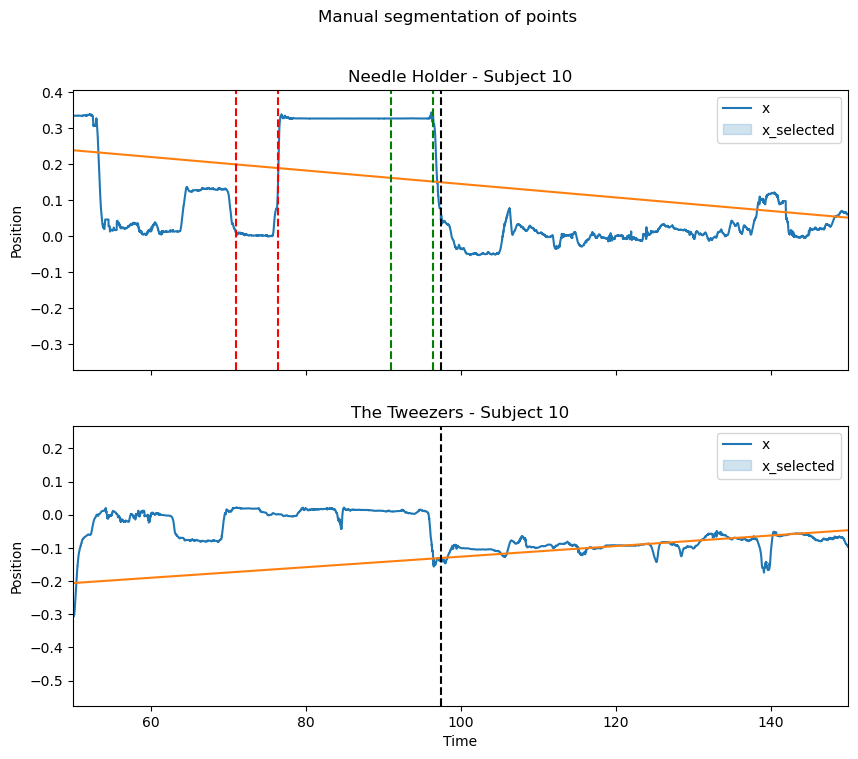

In [131]:
subject = 10

start_t_task = full_segments_time[i]['1'][0]
end_t_task = full_segments_time[i]['8'][1]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
sns.lineplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)
#sns.scatterplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
#sns.scatterplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)
ax1.axvline(x=start_t_task, color='black', linestyle='--')
ax1.axvline(x=end_t_task, color='black', linestyle='--')
ax1.axvline(x=71, color='red', linestyle='--')
ax1.axvline(x=76.5, color='red', linestyle='--')
ax1.axvline(x=91, color='green', linestyle='--')
ax1.axvline(x=96.5, color='green', linestyle='--')
ax1.axvline(x=420, color='black', linestyle='--')
ax1.axvline(x=440, color='black', linestyle='--')
ax1.set_xlim(50,150)

ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_title(f'Needle Holder - Subject {subject}')
ax1.legend(['x', 'x_selected'])

sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
sns.lineplot(x=selected_tw_manual['Time (Seconds)'], y=selected_tw_manual['X.1'], ax=ax2)
ax2.axvline(x=start_t_task, color='black', linestyle='--')
ax2.axvline(x=end_t_task, color='black', linestyle='--')

ax2.set_xlabel('Time')
ax2.set_ylabel('Position')
ax2.legend(['x', 'x_selected'])
ax2.set_title(f'The Tweezers - Subject {subject}')
plt.suptitle('Manual segmentation of points')
plt.show()

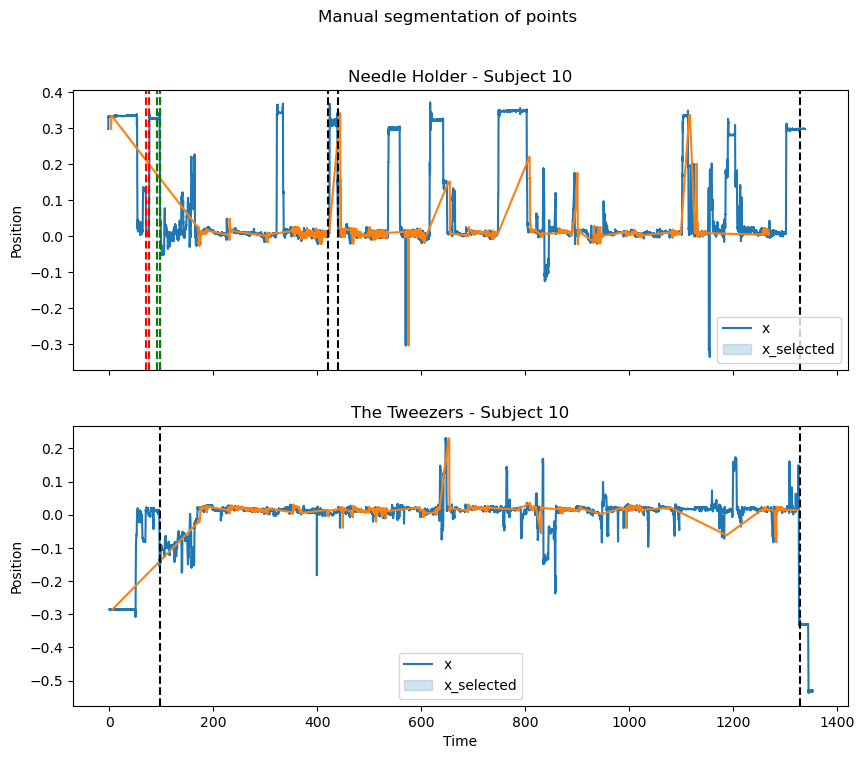

In [136]:
#Adjust the tool tracking time to account for out of sync between video and tracking #le faire avant de selectionner les temps
selected_nh_manual['Time_adjusted'] = selected_nh_manual['Time (Seconds)']+5.5
selected_tw_manual['Time_adjusted'] = selected_tw_manual['Time (Seconds)']+5.5
subject = 10

start_t_task = full_segments_time[i]['1'][0]
end_t_task = full_segments_time[i]['8'][1]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
sns.lineplot(x=selected_nh_manual['Time_adjusted'], y=selected_nh_manual['X.1'], ax=ax1)
#sns.scatterplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
#sns.scatterplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)
ax1.axvline(x=start_t_task, color='black', linestyle='--')
ax1.axvline(x=end_t_task, color='black', linestyle='--')
ax1.axvline(x=71, color='red', linestyle='--')
ax1.axvline(x=76.5, color='red', linestyle='--')
ax1.axvline(x=91, color='green', linestyle='--')
ax1.axvline(x=96.5, color='green', linestyle='--')
ax1.axvline(x=420, color='black', linestyle='--')
ax1.axvline(x=440, color='black', linestyle='--')
#ax1.set_xlim(50,150)

ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_title(f'Needle Holder - Subject {subject}')
ax1.legend(['x', 'x_selected'])

sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
sns.lineplot(x=selected_tw_manual['Time_adjusted'], y=selected_tw_manual['X.1'], ax=ax2)
ax2.axvline(x=start_t_task, color='black', linestyle='--')
ax2.axvline(x=end_t_task, color='black', linestyle='--')

ax2.set_xlabel('Time')
ax2.set_ylabel('Position')
ax2.legend(['x', 'x_selected'])
ax2.set_title(f'The Tweezers - Subject {subject}')
plt.suptitle('Manual segmentation of points')
plt.show()

In [ ]:
i = 6
needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{10}_NH_reconstructed.csv')
tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{10}_TW_reconstructed.csv')